In [11]:

from typing import *
import importlib
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
import seaborn as sns
import pandas as pd
from torch import nn, Tensor
from torch.distributions import Distribution, Dirichlet as TorchDirichlet
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce
from torch.distributions import Bernoulli
from plotting import make_vae_plots
import plotting
importlib.reload(plotting)
import math 
import torch
from torch.nn.functional import softplus
from collections import defaultdict
import torch.nn.functional as F

In [12]:
# Define the train and test sets
dset_train = MNIST("./", train=True,  transform=ToTensor(), download=True)
dset_test  = MNIST("./", train=False, transform=ToTensor())

# The digit classes to use
classes = [3, 7]

def stratified_sampler(labels):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)


In [13]:

batch_size = 64
eval_batch_size = 100
# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.train_labels))
test_loader  = DataLoader(dset_test, batch_size=eval_batch_size, 
                          sampler=stratified_sampler(dset_test.test_labels))
sns.set_style("whitegrid")

images, labels = next(iter(train_loader))

def reduce(x: Tensor) -> Tensor:
    """Reduce only if tensor has more than one dimension."""
    return x if x.ndim == 1 else x.view(x.size(0), -1).sum(dim=-1)

c:\Users\Lauge\anaconda3\envs\DeepLearning\Lib\site-packages\torchvision\datasets\mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [14]:

class VariationalInference(nn.Module):
    def __init__(self, beta: float = 1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model: nn.Module, x: Tensor):
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the KL divergence term
        kl = log_qz - log_pz
        
        # ELBO: log p(x|z) - KL(q||p)
        elbo = log_px - kl
        
        # β-ELBO: log p(x|z) - β * KL(q||p)
        beta_elbo = log_px - self.beta * kl
        
        # loss = -E_q[Lβ]
        loss = -beta_elbo.mean()
        
        # diagnostics for monitoring
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px': log_px, 'kl': kl}
            
        return loss, diagnostics, outputs


In [17]:
from collections import defaultdict
from utils import LatentType
from models.convolutional_vae import ConvolutionalVariationalAutoencoder

# define the models, evaluator and optimizer

# VAE
latent_features = len(classes) # can always be changed
vae = ConvolutionalVariationalAutoencoder(images[0].shape, latent_features, latent_type = LatentType.CONTINUOUSCATEGORICAL)

# Evaluator: Variational Inference
beta = 1
vi = VariationalInference(beta=beta)

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

2


TODO:
- Pull and update code (create utils class)
- Update T-SNE diagram to work with x dimensional latent spaces
- Create one-hot-encoding reconstructions with latent variables like the dirichlet paper
- Save and loading of models
- Explore UMAP and MDS more
- Look more at greyscale transformations

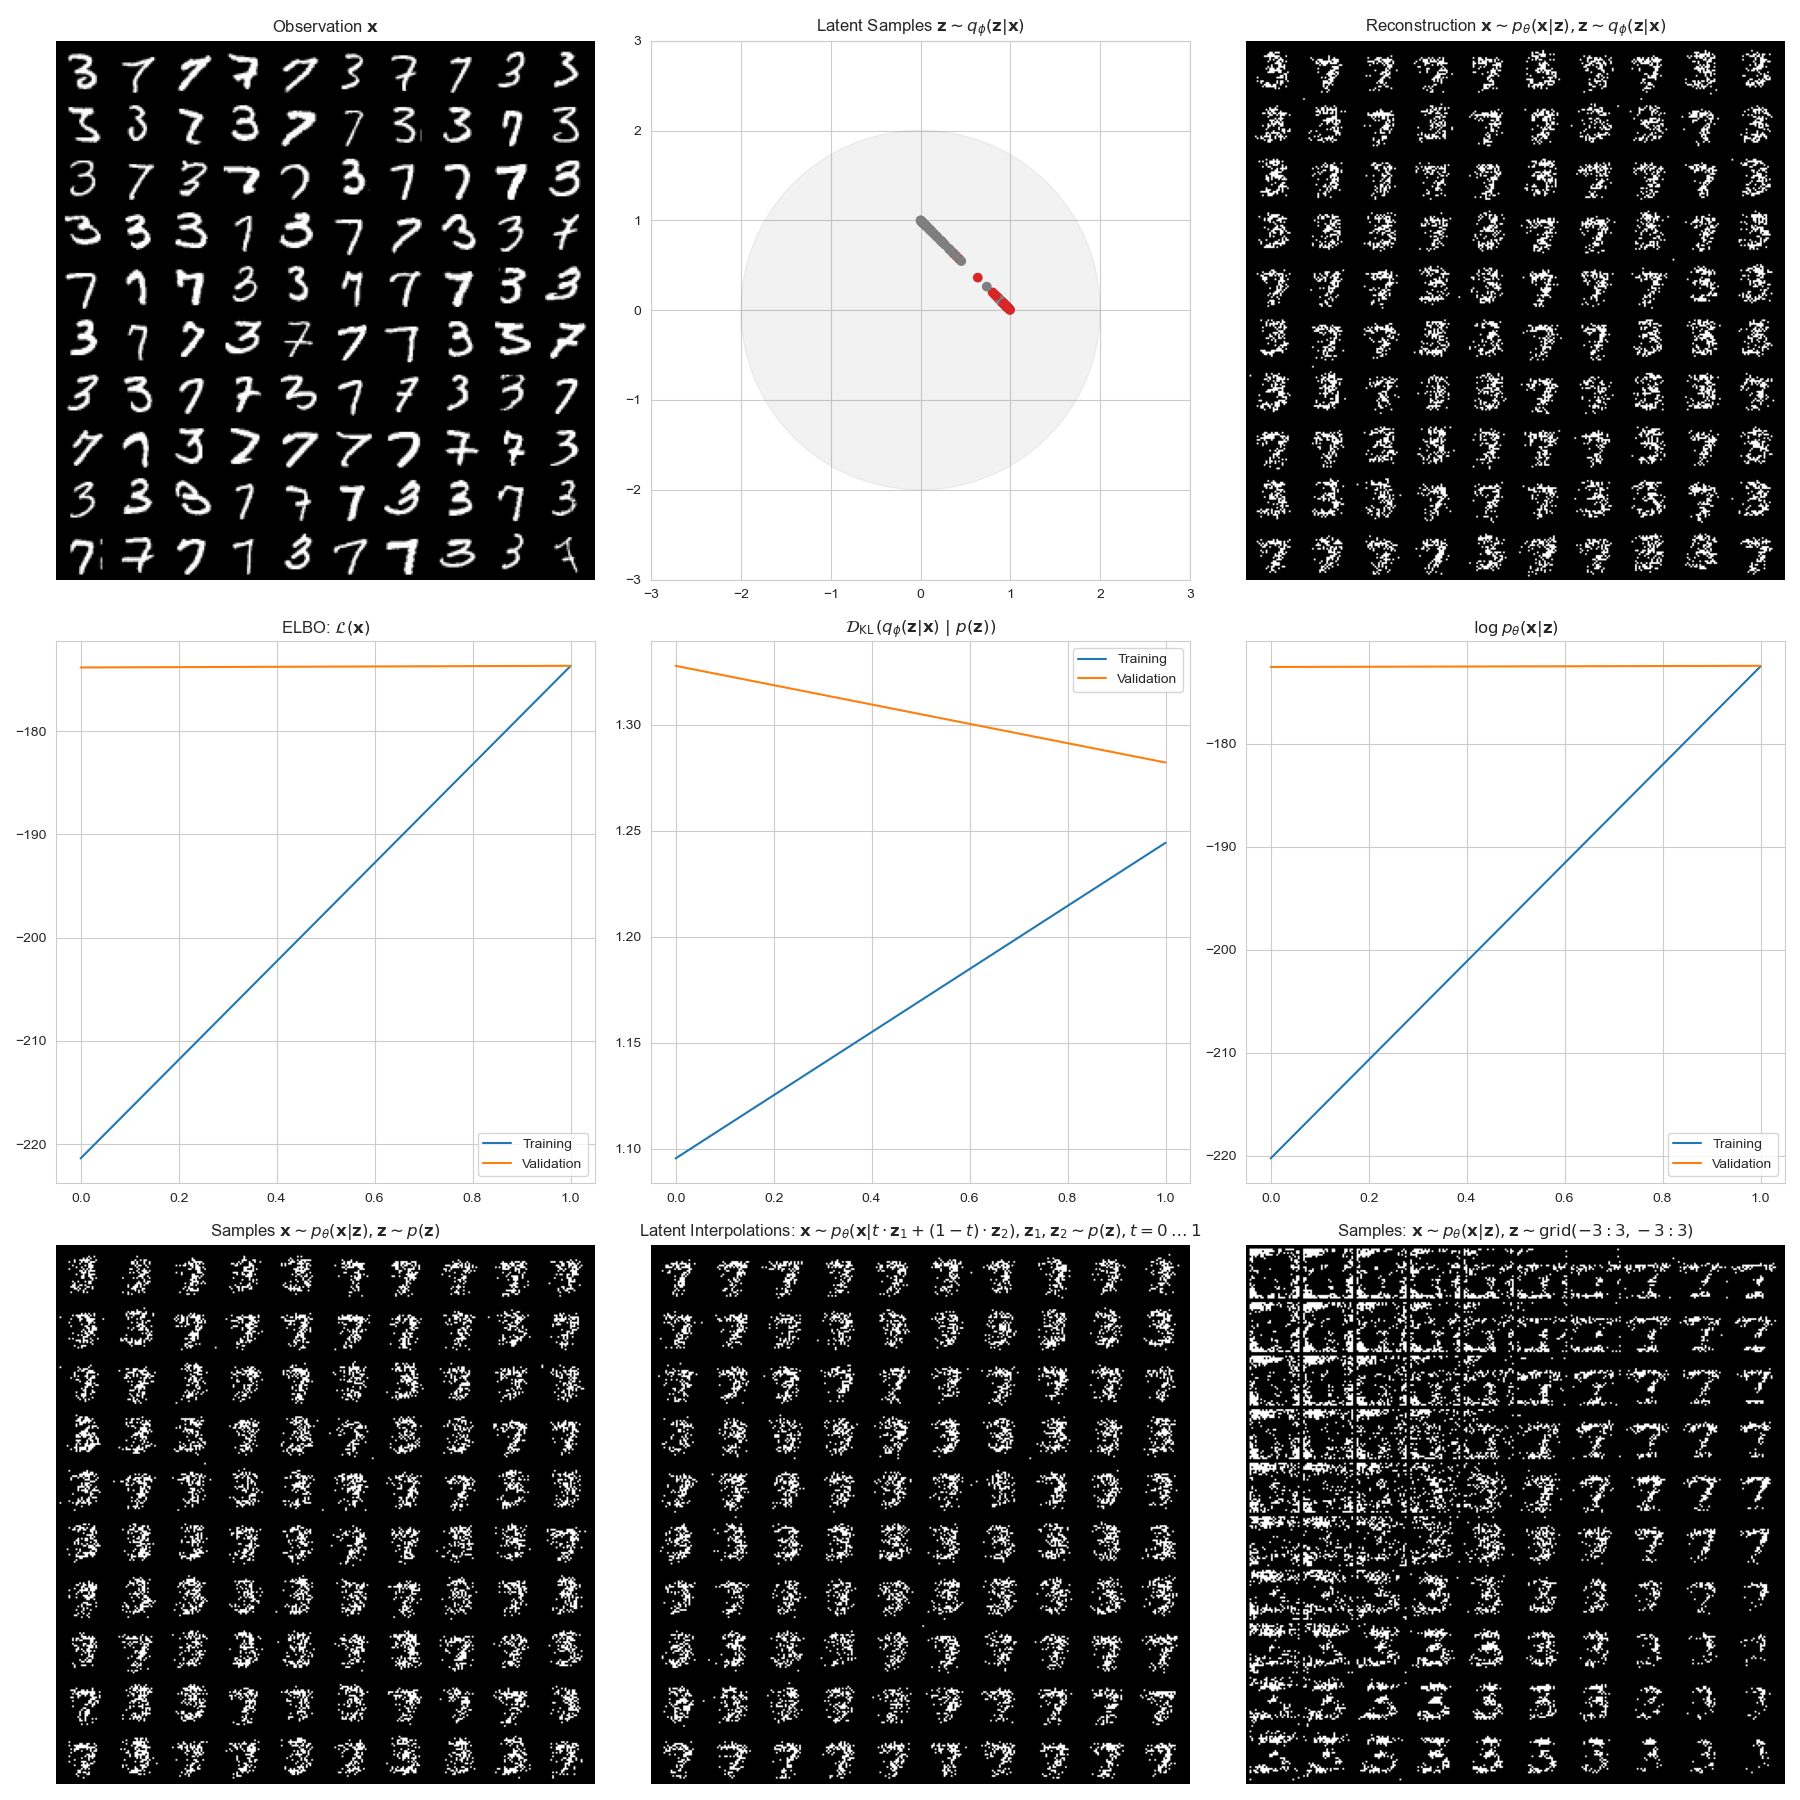

In [18]:
num_epochs = 100
from plotting import make_vae_plots

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

vae = vae.to(device)

# annealing parameters
tau_min = 0.5
anneal_rate = 0.0003
kl_warmup_epochs = 20  # number of epochs to reach full β
max_beta = 0.3

while epoch < num_epochs:
    epoch += 1
    training_epoch_data = defaultdict(list)
    vae.train()

    # KL warmup: gradually increase β
    vi.beta = min(max_beta, epoch / kl_warmup_epochs)

    # temperature annealing (only for continuous categorical)
    if vae.latent_type == LatentType.CONTINUOUSCATEGORICAL:
        vae.tau = max(vae.tau * np.exp(-anneal_rate * epoch), tau_min)

    #print(f"Epoch {epoch}: beta = {vi.beta:.4f}", end="")
    # if vae.latent_type == "continuous_categorical":
    #     print(f", tau = {vae.tau:.4f}")
    # else:
    #     print()

    # training loop
    for x, y in train_loader:
        x = x.to(device)

        loss, diagnostics, outputs = vi(vae, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]

    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    # validation
    with torch.no_grad():
        vae.eval()
        x, y = next(iter(test_loader))
        x = x.to(device)
        loss, diagnostics, outputs = vi(vae, x)
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]

    # visualize
    make_vae_plots(vae, x, y, outputs, training_data, validation_data)


In [ ]:
from plotting import latent_morphing
latent_morphing(vae)